# BUS 244 Genreative AI
## Milestone 1: Data Analysis
#### Samiya Islam, Anokh Palakurthi, Yuming Ruan, Madhurima Roy

***Problem Motivation*** 

Public discourse around U.S. immigration often fluctuates in tone and focus depending on external events which is a from humanitarian crises and policy changes to economic and security shocks. While sentiment analysis provides a sense of whether public attitudes are positive or negative, it does not explain why these attitudes form or how they evolve.

To gain deeper insight, this project extends traditional sentiment analysis into framing analysis such as identifying the underlying narrative “frames” that shape discussions. For instance, immigration can be discussed through humanitarian, economic, security, or political frames. Each frame highlights different aspects of the issue, influencing both public perception and policy discourse.

***Dataset Overview***

The dataset, reddit_sentiment.csv, contains user-generated content related to U.S. immigration topics collected from Reddit.The dataset spans multiple years (2015–2025), capturing shifts in online discussions around immigration during major U.S. policy events.

Key fields include:
- Column	Description
- keyword	Primary keyword used for search/filtering (like “refugee”)
- post_title	Title of the Reddit post
- comment	Reddit user comment or response
- score	Reddit upvote score (proxy for engagement)
- created_utc	Timestamp of comment creation
- sentiment_score	VADER-generated sentiment polarity score
- sentiment_label	Categorized sentiment (positive, neutral, negative)

In [309]:
# Project: U.S. Immigration Framing Analysis

import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



In [310]:
try:
    import nltk
    nltk.data.find('corpora/stopwords')
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
except Exception:
    STOPWORDS = "english"   # pass to TfidfVectorizer to use its built-in stopwords

# 1. Load data
DATA_PATH = "../data/reddit_comments.csv"   # <-- ensure file is in current directory or change path

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded: ../data/reddit_comments.csv shape: (9674, 7)
Columns: ['keyword', 'post_title', 'comment', 'score', 'created_utc', 'sentiment_score', 'sentiment_label']


In [311]:
# Combine title + comment into single text field (if available) and basic cleaning
text_sources = []
if "post_title" in df.columns: text_sources.append("post_title")
if "comment" in df.columns: text_sources.append("comment")
if not text_sources:
    # fallback: first text-like column
    text_sources = [df.columns[0]]

df["text"] = df[text_sources].astype(str).agg(" ".join, axis=1)

def clean_text(s):
    s = str(s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)                    # remove URLs
    s = re.sub(r"\[(.*?)\]\((.*?)\)", r"\1", s)               # convert markdown links [text](url) -> text
    s = re.sub(r"@\w+|\#", " ", s)                            # mentions/hashtags
    s = re.sub(r"[^A-Za-z0-9\s']", " ", s)                    # keep apostrophes optionally if needed
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

df["clean_text"] = df["text"].apply(clean_text)
df = df[df["clean_text"].str.strip() != ""].reset_index(drop=True)
print("After cleaning shape:", df.shape)

# quick peek
display(df.head(3)[["keyword"] + text_sources + ["clean_text"]])


After cleaning shape: (9674, 9)


,keyword,post_title,comment,clean_text
0,immigrant,British expats 'in tears' as Spain to deport 5...,Users often report submissions from this site ...,british expats 'in tears' as spain to deport 5...
1,immigrant,British expats 'in tears' as Spain to deport 5...,I really don’t know what all the whining is ab...,british expats 'in tears' as spain to deport 5...
2,immigrant,British expats 'in tears' as Spain to deport 5...,Seriously why didn't they just register when a...,british expats 'in tears' as spain to deport 5...


In [312]:
# Create annotation sample (200 rows) for manual frame labeling if not already created
SAMPLE_PATH = "frame_labeling_sample.csv"
if not os.path.exists(SAMPLE_PATH):
    # Filter to posts likely relevant to immigration (simple keyword filter)
    filter_keywords = ["immigra", "migrant", "refugee", "border", "asylum", "daca", "illegal", "citizen", "immigration", "deport"]
    df["is_relevant"] = df["clean_text"].apply(lambda x: any(k in x for k in filter_keywords))
    sample_pool = df[df["is_relevant"]].sample(frac=1, random_state=42) if df["is_relevant"].sum() >= 200 else df.sample(frac=1, random_state=42)
    sample = sample_pool.head(200).copy()
    sample["frame_label"] = ""   # to be filled manually by human annotators
    sample.to_csv(SAMPLE_PATH, index=False)
    print(f"Saved a 200-sample file for manual labeling at: {SAMPLE_PATH}")
else:
    print(f"Manual labeling sample already exists at {SAMPLE_PATH}. Use that to annotate frames manually.")

Saved a 200-sample file for manual labeling at: frame_labeling_sample.csv


We selected a set of twelve frames to capture the full spectrum of U.S. immigration discourse from 2015–2025, combining classic framing categories with issues that have gained prominence over the decade. Traditional frames like Humanitarian, Economic, Security, Cultural, and Policy/Legal reflect longstanding debates around moral obligations, labor and economic impacts, national security, societal integration, and legislation. 

Additional frames like Health/Public Health, Political/Partisan, Racial/Ethnic Tensions, Environmental/Climate, Education/Youth, Tech/Surveillance, and International/Geopolitical really capture emergent and temporally relevant topics such as COVID-19, partisan polarization, climate migration, DACA students, surveillance technologies, and global refugee crises. This set allows us to track how Reddit users frame immigration issues across multiple dimensions, reflecting both domestic and international developments.

In [313]:
# Rule-based framing baseline (always run) which is quick and interpretable
def predict_frame_rule_intense_v2(text):
    t = text.lower()
    
    frames = {
        "Humanitarian": ["refugee", "asylum", "human rights", "children", "family separation", 
                         "resettle", "camp", "shelter", "trauma", "victim", "displaced", "crisis", "conflict"],
        "Economic": ["job", "jobs", "economy", "wage", "tax", "work", "business", "employment", 
                     "unemployment", "market", "income", "financial", "burden"],
        "Security": ["border", "illegal", "security", "terror", "crime", "smuggling", 
                     "enforcement", "wall", "threat", "immigration control", "danger", "law enforcement"],
        "Cultural": ["culture", "identity", "language", "values", "tradition", "integration", 
                     "heritage", "customs", "society", "assimilation"],
        "Policy/Legal": ["policy", "law", "daca", "court", "executive order", "legislation", 
                         "bill", "administration", "immigration policy", "public charge", "regulation", "decree"],
        "Health/Public Health": ["covid", "pandemic", "vaccine", "disease", "healthcare", "epidemic", "hospital", "quarantine"],
        "Political/Partisan": ["trump", "biden", "election", "republican", "democrat", "party", "campaign", "politics", "politician"],
        "Racial/Ethnic Tensions": ["racism", "xenophobia", "discrimination", "prejudice", "minority", "hate crime"],
        "Environmental / Climate": ["climate refugee", "natural disaster", "flood", "hurricane", "drought", "sea level", "environmental migration"],
        "Education / Youth": ["student visa", "daca student", "school", "college", "university", "education", "children education"],
        "Tech / Surveillance": ["surveillance", "facial recognition", "border tech", "ai monitoring", "data collection"],
        "International / Geopolitical": ["syria", "afghanistan", "central america", "unhcr", "un refugee", "war", "conflict zone", "foreign policy"]
    }
    
    # Count matches per frame
    frame_scores = {k: sum(1 for kw in v if re.search(r'\b' + re.escape(kw) + r'\b', t)) for k,v in frames.items()}
    
    if all(score == 0 for score in frame_scores.values()):
        return "Other"
    
    # Return frame(s) with highest score; if tie, return list joined
    max_score = max(frame_scores.values())
    top_frames = [f for f, s in frame_scores.items() if s == max_score]
    return ", ".join(top_frames)

df["frame_rule"] = df["clean_text"].apply(predict_frame_rule_intense_v2)
print("Rule-based frame distribution:")
print(df["frame_rule"].value_counts())



Rule-based frame distribution:
frame_rule
Other                                                                                 3224
Political/Partisan                                                                    2725
Security                                                                               899
Policy/Legal                                                                           834
Humanitarian, Political/Partisan                                                       426
                                                                                      ... 
Tech / Surveillance                                                                      1
Security, Political/Partisan, International / Geopolitical                               1
Cultural, Political/Partisan, Racial/Ethnic Tensions, Education / Youth                  1
Humanitarian, Economic, Political/Partisan, Racial/Ethnic Tensions                       1
Humanitarian, Security, Cultural, Political/Part

Individual frame distribution (all frames counted separately):
frame_rule_list
Political/Partisan              3716
Other                           3224
Security                        1185
Policy/Legal                    1167
Humanitarian                     759
Economic                         548
Cultural                         208
International / Geopolitical     181
Education / Youth                125
Health/Public Health              89
Racial/Ethnic Tensions            67
Environmental / Climate            5
Tech / Surveillance                1
Name: count, dtype: int64


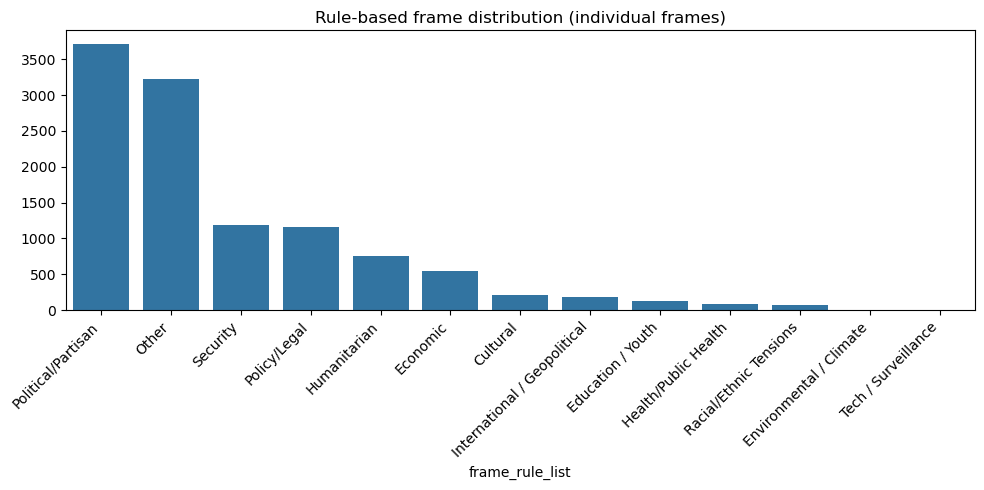

In [314]:
# Split comma-separated frames into lists
df['frame_rule_list'] = df['frame_rule'].str.split(',\s*')

# Explode so each frame gets its own row
df_exploded = df.explode('frame_rule_list')

# Count each individual frame
frame_counts = df_exploded['frame_rule_list'].value_counts()

print("Individual frame distribution (all frames counted separately):")
print(frame_counts)

# Optional: plot
plt.figure(figsize=(10,5))
sns.barplot(x=frame_counts.index, y=frame_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Rule-based frame distribution (individual frames)")
plt.tight_layout()
plt.show()

In [315]:
# Save intermediate output
df.to_csv("reddit_cleaned_and_rule_frame.csv", index=False)
print("Saved: reddit_cleaned_and_rule_frame.csv")

Saved: reddit_cleaned_and_rule_frame.csv


In [316]:
#  Baseline model for SENTIMENT (TF-IDF + Logistic Regression) if sentiment_label exists
if "sentiment_label" in df.columns:
    print("\n--- Sentiment baseline training ---")
    # Filter to the common labels
    df_sent = df[df["sentiment_label"].notna()].copy()
    df_sent["sentiment_label"] = df_sent["sentiment_label"].astype(str).str.lower().str.strip()
    allowed = ["positive", "neutral", "negative"]
    df_sent = df_sent[df_sent["sentiment_label"].isin(allowed)]
    if df_sent.shape[0] < 50:
        print("Not enough labeled sentiment rows to train a model (need >= ~50). Rows available:", df_sent.shape[0])
    else:
        X = df_sent["clean_text"]
        y = df_sent["sentiment_label"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

        # Ensure STOPWORDS is in a format accepted by TfidfVectorizer
        # TfidfVectorizer expects stop_words to be one of: None, 'english', or a list
        if isinstance(STOPWORDS, (set, frozenset)):
            stop_words_param = list(STOPWORDS)
        elif isinstance(STOPWORDS, list) or isinstance(STOPWORDS, str) or STOPWORDS is None:
            stop_words_param = STOPWORDS
        else:
            # fallback to 'english' if unexpected type
            stop_words_param = "english"

        vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words=stop_words_param)
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        clf = LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga", multi_class="multinomial", random_state=42)
        clf.fit(X_train_tfidf, y_train)
        preds = clf.predict(X_test_tfidf)
        print("Sentiment classification report:")
        print(classification_report(y_test, preds, digits=3))
        print("Accuracy:", accuracy_score(y_test, preds))
        # Save model artifacts (optional)
        # You can pickle vectorizer and clf if you want to reuse them later

else:
    print("\nNo 'sentiment_label' column present — skipping sentiment baseline training.")


--- Sentiment baseline training ---
Sentiment classification report:
              precision    recall  f1-score   support

    negative      0.808     0.758     0.782       685
     neutral      0.732     0.881     0.800       556
    positive      0.824     0.741     0.780       694

    accuracy                          0.787      1935
   macro avg      0.788     0.793     0.787      1935
weighted avg      0.792     0.787     0.787      1935

Accuracy: 0.7870801033591731


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Research & Related Literature

### Framing Theory Foundations

The concept of “framing” in communication and political discourse originates in part with Robert M. Entman, who defined framing as the process of selecting certain aspects of perceived reality and making them *more salient* in a communicating text in order to promote particular problem definitions, causal interpretations, moral evaluations, and/or treatment recommendations. ([Frank Baumgartner][1]) This definition remains widely used: selection + salience = framing. ([Provalis Research][2])
Entman’s articulation also emphasizes four key functions of frames:

1. **Problem definition** : identifying an issue as a problem,
2. **Causal interpretation** : attributing cause(s) to the problem,
3. **Moral evaluation** : judging actors/behaviours as good or bad,
4. **Treatment recommendation** :  suggesting solutions or responses. ([Frank Baumgartner][1])
   This theoretical foundation helps to shape how we interpret public discourse on immigration: when Reddit posts discuss immigration, we can ask not only *what is being said*, but *how* the issue is framed (e.g., as a security threat vs. humanitarian opportunity) and what kinds of solutions or moral judgements are implied.

### Framing in Media and Policy Discourse

In the political science and communication literatures, framing has been used to assess how media and policy discussions evolve and how they differ across issues. For example, the study by Amber E. Boydstun, Dallas Card, Justin H. Gross, Philip Resnik and Noah A. Smith (“Tracking the Development of Media Frames within and across Policy Issues”, 2014) examines frame dynamics across multiple policy domains. They show that frame prevalence shifts over time and differs by policy domain. ([Homes at Washington][3]) Their work is helpful for our project in two ways:

* It shows the importance of tracking **frame dynamics** (how frames evolve) rather than treating framing as static;
* It reinforces that framing analysis can extend beyond media texts into policy contexts and over time, which aligns with our interest in how Reddit discourse around immigration changes following external shocks.
  Using this as a precedent, we treat Reddit data as a form of public discourse where frame evolution can be observed.

### Framing in Social Media, Specifically Immigration Discourse

The third paper, by Julia Mendelsohn, Ceren Budak and David Jurgens (2021), “Modeling Framing in Immigration Discourse on Social Media” (NAACL 2021) is directly aligned with your project. ([ACL Anthology][4]) They create a labeled dataset of immigration-related tweets, categorize frames (including immigration-specific ones and generic issue ones), and demonstrate how user ideology, region, and engagement behaviors (retweets/favorites) correlate with framing. Some key findings include:

* Generic, issue-agnostic frames may obscure important patterns; immigration-specific frames reveal region/ideology differences. ([ACL Anthology][5])
* Frames oriented toward human interest, culture, and politics tend to have *higher engagement* on social media. ([ACL Anthology][4])
  This work gives strong support for our approach: using Reddit (similar to Twitter) and focusing on framing, not just sentiment, for immigration discourse. It also suggests that framing classification on social media is feasible and meaningful.


[1]: https://fbaum.unc.edu/teaching/articles/J-Communication-1993-Entman.pdf?utm_source=chatgpt.com "[PDF] Framing: Toward Clarification of a Fractured Paradigm"
[2]: https://provalisresearch.com/solutions-2/applications/what-is-media-framing-analysis-2/?utm_source=chatgpt.com "What is Media Framing Analysis? - Provalis Research"
[3]: https://homes.cs.washington.edu/~nasmith/papers/boydstun%2Bcard%2Bgross%2Bresnik%2Bsmith.apsa14.pdf?utm_source=chatgpt.com "Tracking the Development of Media Frames within and ..."
[4]: https://aclanthology.org/2021.naacl-main.179.pdf?utm_source=chatgpt.com "Modeling Framing in Immigration Discourse on Social Media"
[5]: https://aclanthology.org/2021.naacl-main.179/?utm_source=chatgpt.com "Modeling Framing in Immigration Discourse on Social Media"



## Moving Forward

### How we’ll adopt their method for Mileshtone 2

1. **Frame codebook / definitions**

   * For each frame, document: what kinds of discourse it includes, sample keywords, criteria for labeling.
   * Decide: Will posts allow multiple frames or only one primary frame? (Prior studies allow overlapping but designate a primary frame.)
   
2. **Manual labeling / seed dataset creation**

   * Sample 150–200 posts (as we previously planned).
   * Have at least two annotators label each post (frame category, maybe secondary frame).
3. **Automated labeling / supervised model**

   * Use the manually labelled seed set to train or test a simple classifier (or few-shot LLM prompt) that assigns frames to the full Reddit dataset.
   * Prior work used supervised models and showed performance per frame; we may do a simpler version (heuristic, few-shot) given our timeframe.
   * Evaluate the model by comparing its predictions to the seed set (precision/recall/F1, confusion matrix).
4. **Frame dynamics & temporal/event analysis**

   * Once every post has a frame label (manual or automated), explore how frame prevalence changes over time.
   * Link frame prevalence to external events (e.g., travel bans, refugee surges).
   * Optionally explore how sentiment interacts with frames: e.g., do certain frames tend to be more negative than others?

5. **Ethical, data and limitations section**

   * Prior work emphasises transparency in annotation & modelling. 
   * Include how we collected data, how we anonymised it, handled biases, will paraphrase instead of quoting verbatim.
